In [1]:
%load_ext autoreload
%autoreload 2

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools

from IPython.display import display, clear_output

from iarchitect import envs,trainer as trainer_iarch
from iarchitect.agents import dqn as dqn_iarch
from iarchitect.common import show_policy_behaviour
from iarchitect.common.callbacks import output_updater

from tf_agents.agents import DdpgAgent,DqnAgent

from tf_agents.utils import common
from tf_agents import networks
from tf_agents.networks import sequential
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics,tf_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

from tensorflow import Tensor,Variable
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import initializers

In [98]:
environment = envs.AlignedRowEnv(4,action_float=False,
                            fail_on_same=True,
                            observation_1D = False,
                           rewards = {
                     "already_filled":-10,
                     "max_iter":-10,
                     "new_value":1,
                     "success":10
                 })
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

In [99]:
def dense_layer(num_units):
    return layers.Dense(
        num_units,
        activation="relu",
        kernel_initializer=initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))
def network(fc_layers_units,dimension_q_values):
    q_values_layer = layers.Dense(
            dimension_q_values,
            activation=None,
            kernel_initializer=initializers.RandomUniform(
                minval=-0.03, maxval=0.03),
            bias_initializer=initializers.Constant(-0.2))
    return sequential.Sequential([layers.Flatten()] + [dense_layer(n) for n in fc_layers_units] + [q_values_layer])


In [100]:
agent = DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=network((20,20),environment.dimension),
        optimizer=Adam(learning_rate=0.0005),
        td_errors_loss_fn=common.element_wise_squared_loss,)
agent.initialize()

In [101]:
def show_agent_behavior(tf_env,agent,ax,axes):
    results = show_policy_behaviour(tf_env,trainer.agent.policy,50)
#     ax.plot([r[0] for r in results],label="action")
    ax.plot([r[1] for r in results],label="reward")
    n = min(len(results),len(axes))
    for ax_,res in zip(axes[:n],[r[2] for r in results[:n]]):
        ax_.imshow(res[0,:])

In [102]:
def update_plotter(fig):
    def update_plot(step,trainer):
        
        for ax in fig.axes:
            ax.clear()
        
        ax,ax2,ax3,ax4 = fig.axes[:4]
        axes = fig.axes[4:]

        ax.plot(trainer.metrics,label="metric",color="green")
        losses = trainer.losses.reshape((-1,2))
        ax2.plot(losses[:,0],label="actor_loss",color="red")
        ax2.plot(losses[:,1],label="critic_loss",color="green")
        
        trainer.observer.plot_reward(ax=ax3,slice_=slice(-50,None,None))
        trainer.observer.plot_action(ax=ax3,slice_=slice(-50,None,None))
        show_agent_behavior(trainer.tf_env,trainer.agent,ax4,axes)
        ax.legend()
        ax2.legend()        
    return update_plot

In [103]:
def fig_trainer(r,c):
    assert r%3==0
    fig = plt.figure(figsize=(20,20))
    gs = GridSpec(r, c,width_ratios=[1,1]+[1/(c-2)]*(c-2))
    ax = fig.add_subplot(gs[0:r//3,0])
    ax2 = fig.add_subplot(gs[r//3:r//3*2,0])
    ax3 = fig.add_subplot(gs[r//3*2:,0])
    ax4 = fig.add_subplot(gs[:,1])
    axes =[fig.add_subplot(gs[i,j+2]) for i,j in itertools.product(range(r),range(c-2))]
    return fig

In [104]:
trainer = trainer_iarch.Trainer(train_env,agent)
trainer.initialize_buffer(min_size=1000,random_policy=True)

KeyboardInterrupt: 

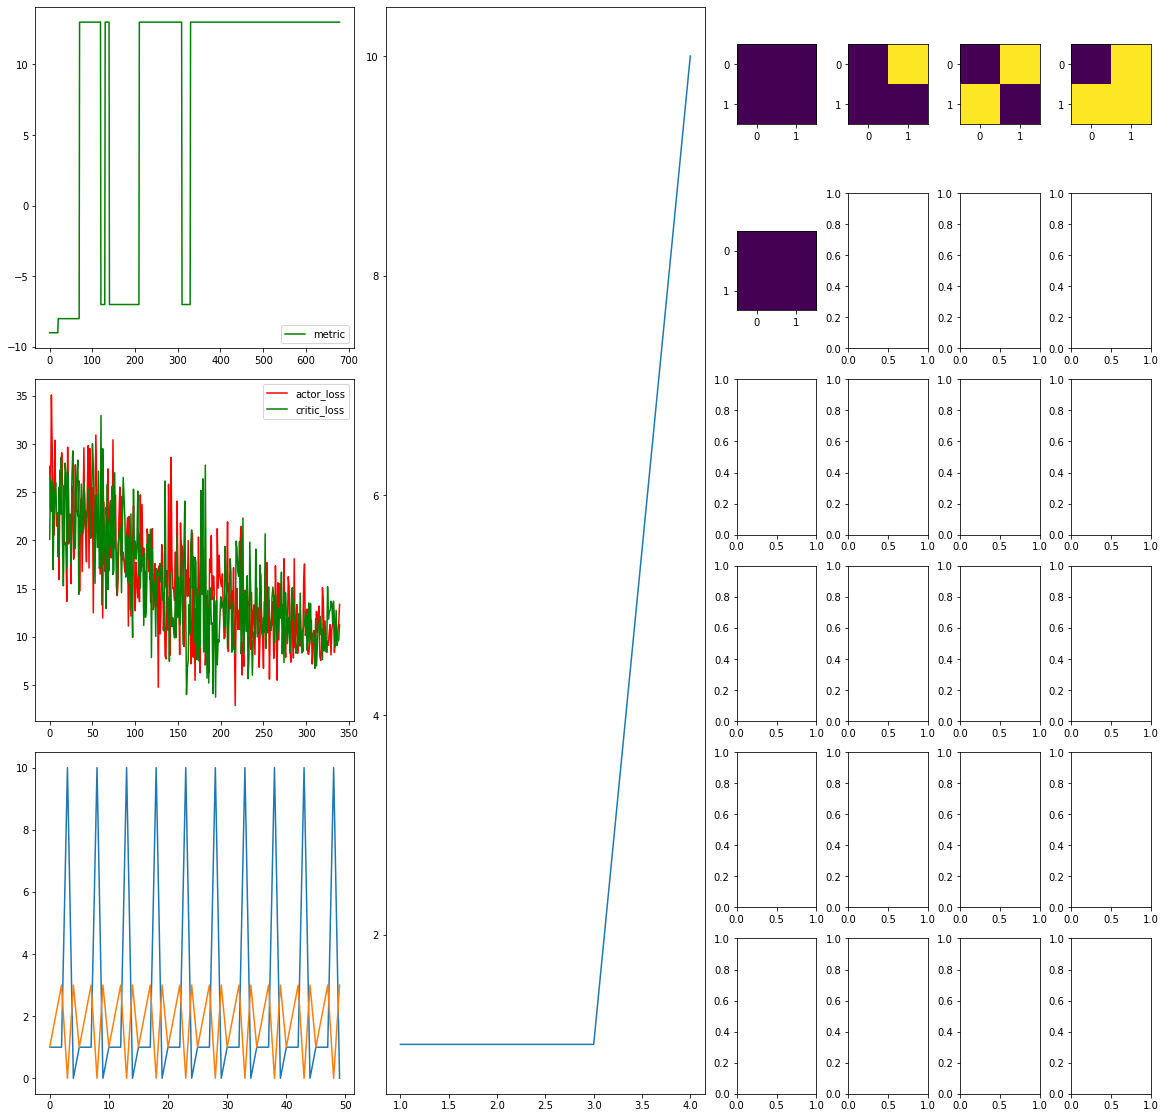

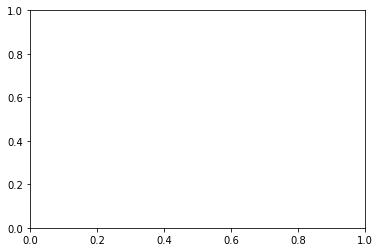

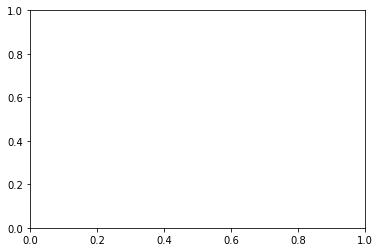

In [94]:
fig_tr = fig_trainer(6,6)
fig_dist = plt.figure()
plt.subplot()
fig_buf = plt.figure()
plt.subplot()

callbacks = [update_plotter(fig_tr),
             output_updater(fig_tr,fig_dist)
             ]



trainer.run(callbacks=callbacks,
            buffer_size_increase_per_iteration = 10,
            sample_batch_size_experience = 64,
            num_iterations_train = 10,
            num_steps_per_row_in_experience = 2
           )

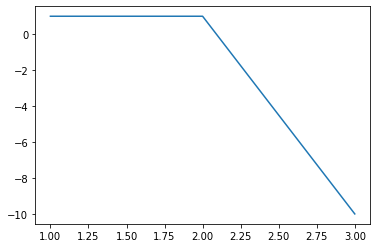

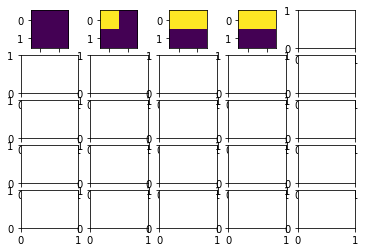

In [111]:
trainer.tf_env.reset()
fig,ax = plt.subplots()
fig2,axes_ = plt.subplots(5,5)
show_agent_behavior(trainer.tf_env,trainer.agent,ax,fig2.axes)

In [108]:
results = show_policy_behaviour(trainer.tf_env,trainer.agent.policy,50)
results

[(None,
  None,
  array([[[1, 1],
          [0, 0]]], dtype=int32))]